In [16]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import urllib.request

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
data_path = "smsspamcollection.zip"
urllib.request.urlretrieve(url, data_path)

# Extract and read
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(".")

df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=["label", "message"])
df.head()

In [3]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['message']).toarray()
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
print("Applying PCA...")
start_pca = time.time()
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
end_pca = time.time()
pca_time = end_pca - start_pca
print(f"PCA completed in {pca_time:.2f} seconds. Shape: {X_train_pca.shape}")

Applying PCA...
PCA completed in 1.55 seconds. Shape: (4457, 200)


In [14]:
from sklearn.neural_network import BernoulliRBM
from scipy.special import expit  # Sigmoid
import numpy as np
import time

# Binarize data
X_train_bin = np.where(X_train > 0.5, 1, 0)
X_test_bin = np.where(X_test > 0.5, 1, 0)

# Hyperparameter ranges
components_list = [100, 150, 200]
learning_rates = [0.01, 0.05]
n_iters = [10, 15]

print("RBM tuning based on reconstruction error:")
best_score = float('inf')
best_params = {}
best_rbm_model = None

for n_comp in components_list:
    for lr in learning_rates:
        for n_iter in n_iters:
            rbm = BernoulliRBM(n_components=n_comp, learning_rate=lr, n_iter=n_iter, random_state=42, verbose=False)
            rbm.fit(X_train_bin)

            # Forward pass (hidden layer)
            X_hidden = rbm.transform(X_train_bin)

            # Approximate reconstruction using sigmoid(dot(hidden, components))
            X_recon = expit(np.dot(X_hidden, rbm.components_))

            # Reconstruction error
            recon_error = np.mean(np.square(X_train_bin - X_recon))

            print(f"n_components={n_comp}, lr={lr}, n_iter={n_iter} → Recon error: {recon_error:.4f}")

            if recon_error < best_score:
                best_score = recon_error
                best_params = {'n_components': n_comp, 'learning_rate': lr, 'n_iter': n_iter}
                best_rbm_model = rbm

# Print best result
print("\n✅ Best RBM Params:")
print(best_params)
print(f"Best reconstruction error: {best_score:.4f}")

# Final transformation
start_rbm = time.time()
X_train_rbm = best_rbm_model.transform(X_train_bin)
X_test_rbm = best_rbm_model.transform(X_test_bin)
end_rbm = time.time()
print(f"🏁 RBM transformation done in {end_rbm - start_rbm:.2f} seconds. Shape: {X_train_rbm.shape}")


RBM tuning based on reconstruction error:
n_components=100, lr=0.01, n_iter=10 → Recon error: 0.0012
n_components=100, lr=0.01, n_iter=15 → Recon error: 0.0012
n_components=100, lr=0.05, n_iter=10 → Recon error: 0.0013
n_components=100, lr=0.05, n_iter=15 → Recon error: 0.0012
n_components=150, lr=0.01, n_iter=10 → Recon error: 0.0012
n_components=150, lr=0.01, n_iter=15 → Recon error: 0.0012
n_components=150, lr=0.05, n_iter=10 → Recon error: 0.0012
n_components=150, lr=0.05, n_iter=15 → Recon error: 0.0012
n_components=200, lr=0.01, n_iter=10 → Recon error: 0.0012
n_components=200, lr=0.01, n_iter=15 → Recon error: 0.0012
n_components=200, lr=0.05, n_iter=10 → Recon error: 0.0012
n_components=200, lr=0.05, n_iter=15 → Recon error: 0.0012

✅ Best RBM Params:
{'n_components': 200, 'learning_rate': 0.01, 'n_iter': 15}
Best reconstruction error: 0.0012
🏁 RBM transformation done in 0.28 seconds. Shape: (4457, 200)


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

# Step 5: Define Classifier
models = {
    "Random Forest": RandomForestClassifier()
}

def evaluate_models(models, datasets, dataset_names):
    results = []
    for (X_tr, X_te), name in zip(datasets, dataset_names):
        for model_name, model in models.items():
            clf = model
            clf.fit(X_tr, y_train)
            y_pred = clf.predict(X_te)
            acc = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            results.append({
                "Feature Set": name,
                "Model": model_name,
                "Accuracy": acc,
                "Confusion Matrix": cm,
                "Classification Report": report
            })
    return results

# Step 7: Run Evaluation
datasets = [(X_train, X_test), (X_train_pca, X_test_pca), (X_train_rbm, X_test_rbm)]
dataset_names = ['Original', 'PCA', 'RBM']
results = evaluate_models(models, datasets, dataset_names)

# Step 8: Print Reports
for result in results:
    print("="*60)
    print(f"Feature Set: {result['Feature Set']}")
    print(f"Model: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Classification Report:")
    print(pd.DataFrame(result["Classification Report"]).transpose())
    print()

# Step 9: Accuracy Visualization
results_df = pd.DataFrame([{
    "Feature Set": r["Feature Set"],
    "Model": r["Model"],
    "Accuracy": r["Accuracy"]
} for r in results])


Feature Set: Original
Model: Random Forest
Accuracy: 0.9839
Classification Report:
              precision    recall  f1-score      support
0              0.982688  0.998965  0.990760   966.000000
1              0.992481  0.885906  0.936170   149.000000
accuracy       0.983857  0.983857  0.983857     0.983857
macro avg      0.987585  0.942435  0.963465  1115.000000
weighted avg   0.983997  0.983857  0.983465  1115.000000

Feature Set: PCA
Model: Random Forest
Accuracy: 0.9731
Classification Report:
              precision    recall  f1-score      support
0              0.972727  0.996894  0.984663   966.000000
1              0.976000  0.818792  0.890511   149.000000
accuracy       0.973094  0.973094  0.973094     0.973094
macro avg      0.974364  0.907843  0.937587  1115.000000
weighted avg   0.973165  0.973094  0.972081  1115.000000

Feature Set: RBM
Model: Random Forest
Accuracy: 0.8933
Classification Report:
              precision    recall  f1-score      support
0              0.8

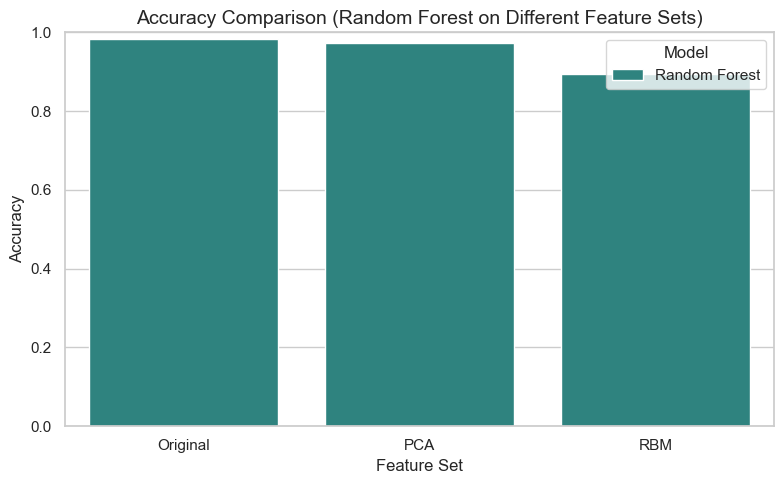

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Filter accuracy scores for plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Feature Set", y="Accuracy", hue="Model", palette="viridis")

plt.title("Accuracy Comparison (Random Forest on Different Feature Sets)", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.xlabel("Feature Set")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_16580\799283484.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


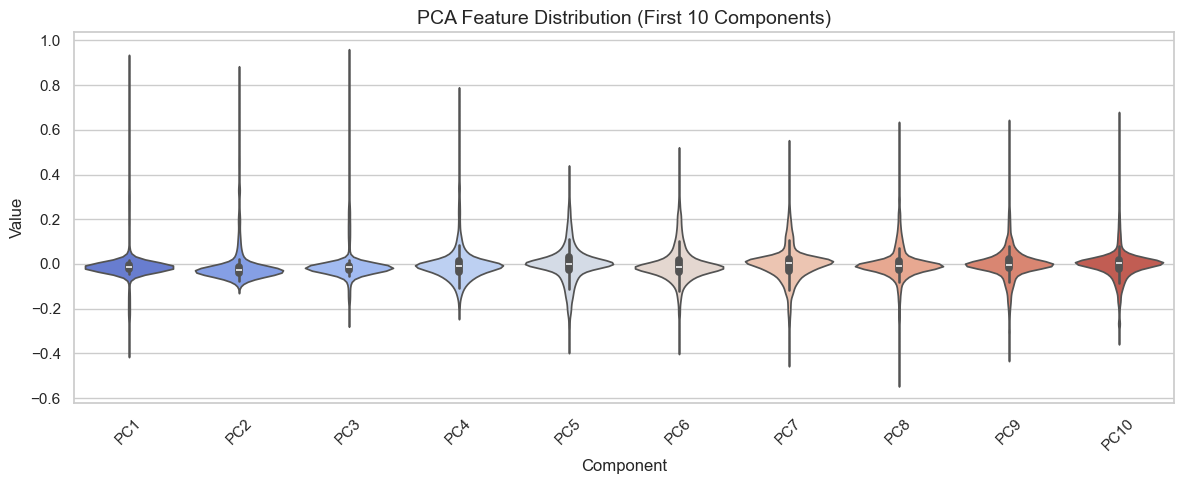

C:\Users\HP\AppData\Local\Temp\ipykernel_16580\799283484.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


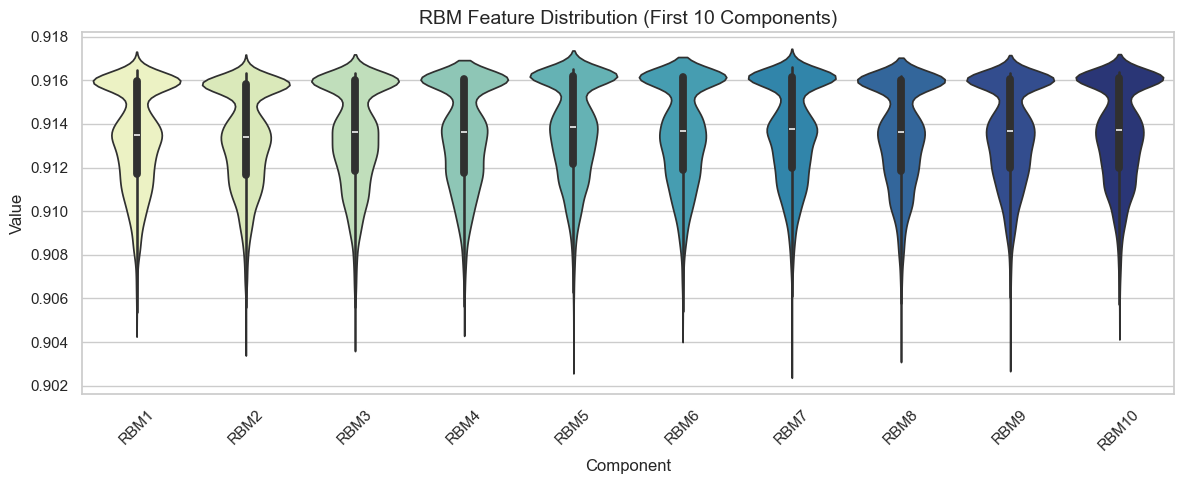

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot settings
sns.set(style="whitegrid")

# Sample first 10 components for cleaner visualization
n_components_to_plot = 10
X_pca_plot = pd.DataFrame(X_train_pca[:, :n_components_to_plot], columns=[f'PC{i+1}' for i in range(n_components_to_plot)])
X_rbm_plot = pd.DataFrame(X_train_rbm[:, :n_components_to_plot], columns=[f'RBM{i+1}' for i in range(n_components_to_plot)])

# Melt into long-form format for Seaborn
X_pca_melted = X_pca_plot.melt(var_name="Component", value_name="Value")
X_rbm_melted = X_rbm_plot.melt(var_name="Component", value_name="Value")

# -------------------- PCA Violin Plot --------------------
plt.figure(figsize=(12, 5))
sns.violinplot(
    data=X_pca_melted, 
    x="Component", 
    y="Value", 
    palette="coolwarm"
)
plt.title("PCA Feature Distribution (First 10 Components)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------- RBM Violin Plot --------------------
plt.figure(figsize=(12, 5))
sns.violinplot(
    data=X_rbm_melted, 
    x="Component", 
    y="Value", 
    palette="YlGnBu"
)
plt.title("RBM Feature Distribution (First 10 Components)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


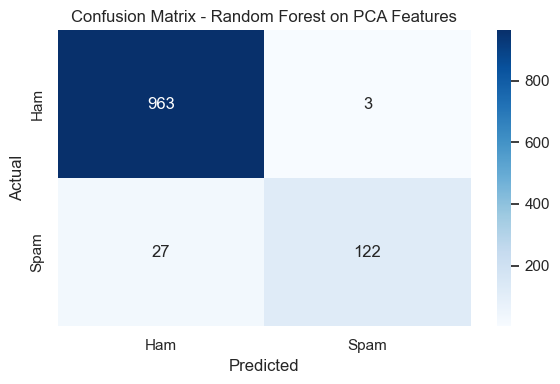

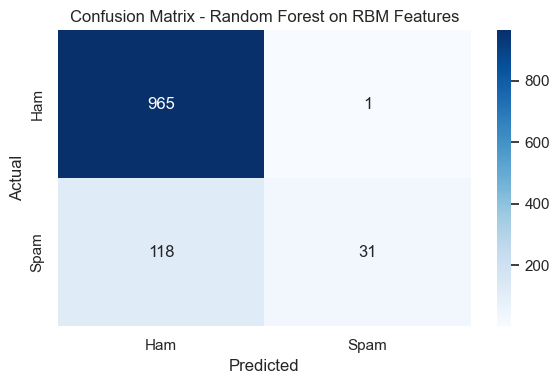

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Filter only PCA and RBM confusion matrices
for name in ['PCA', 'RBM']:
    for result in results:
        if result['Feature Set'] == name and result['Model'] == 'Random Forest':
            cm = result['Confusion Matrix']
            labels = ['Ham', 'Spam']  # or use sorted(set(y_test)) if dynamic
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
            plt.title(f"Confusion Matrix - Random Forest on {name} Features")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.show()


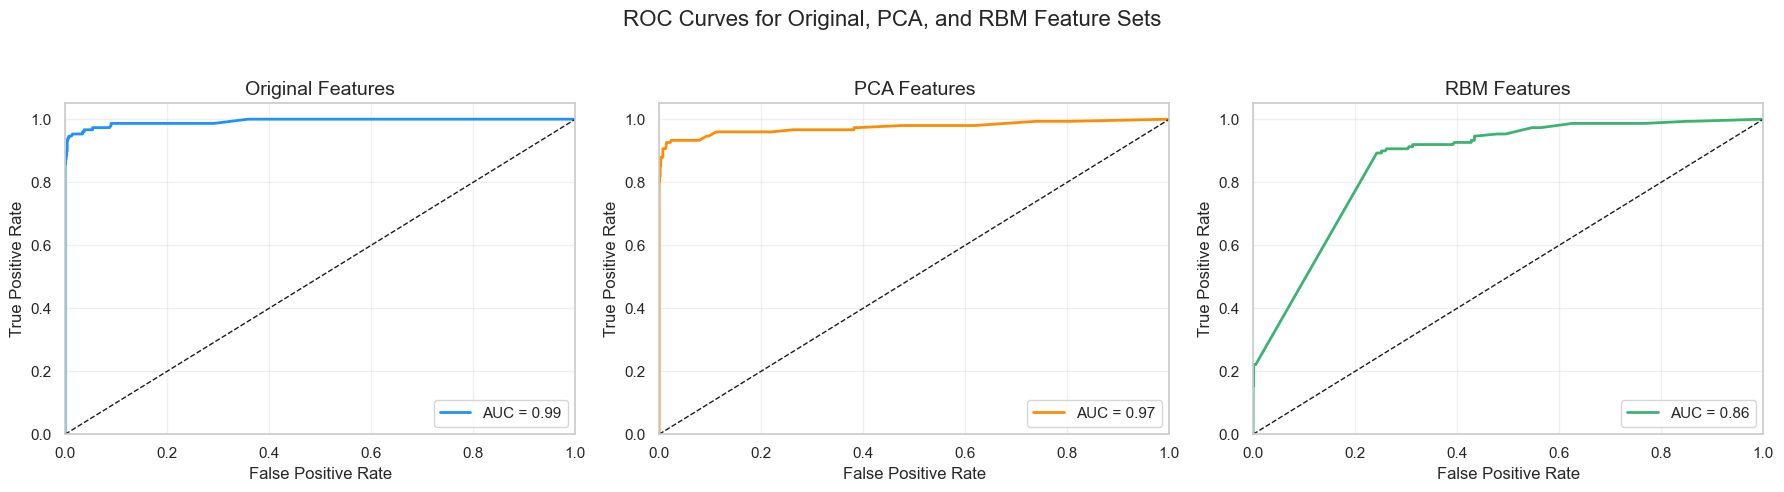

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier

# Binarize y_test for binary classification
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()

# Feature sets and names
feature_sets = {
    'Original': (X_train, X_test),
    'PCA': (X_train_pca, X_test_pca),
    'RBM': (X_train_rbm, X_test_rbm)
}

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['dodgerblue', 'darkorange', 'mediumseagreen']

for ax, (name, (X_tr, X_te)), color in zip(axes, feature_sets.items(), colors):
    # Train a new classifier for each set
    clf = RandomForestClassifier()
    clf.fit(X_tr, y_train)

    # Predict probabilities and compute ROC
    y_proba = clf.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    ax.plot(fpr, tpr, color=color, lw=2, label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(f'{name} Features', fontsize=14)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.suptitle('ROC Curves for Original, PCA, and RBM Feature Sets', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
